# Module 2: How ColPali Models Work

Install or upgrade `fastembed` with ColPali model support.

In [2]:
!pip install -U -q tokenizers fastembed


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Load the ColPali model. Unlike text-only ColBERT, ColPali processes document images directly and produces patch-level embeddings.

In [3]:
from fastembed import LateInteractionMultimodalEmbedding

# Load the Qdrant/colpali-v1.3-fp16 model from HF hub
colpali_model = LateInteractionMultimodalEmbedding(
    model_name="Qdrant/colpali-v1.3-fp16"
)

Load a sample newspaper page image that we'll use as our document.

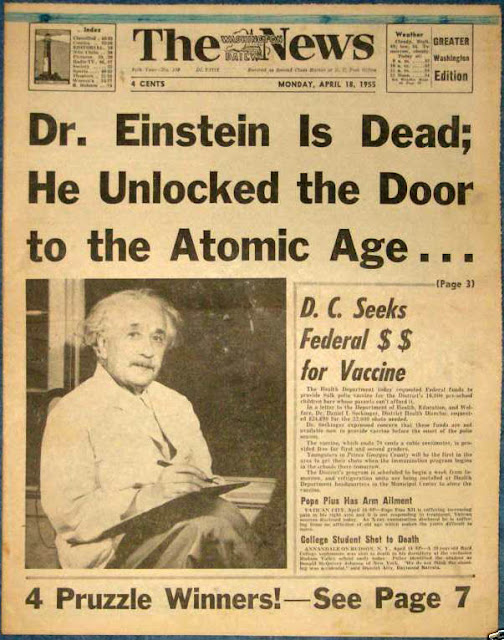

In [4]:
from PIL import Image

image = Image.open("images/einstein-newspaper.jpg")
image

Generate the image's multi-vector representation. ColPali produces 1030 vectors (1024 image patches + 6 instruction tokens), each 128-dimensional.

In [5]:
# Create the representation of the image
colpali_generator = colpali_model.embed_image(["images/einstein-newspaper.jpg"])
document_vectors = next(colpali_generator)
document_vectors.shape

(1030, 128)

Embed a text query into the same vector space. The query gets one vector per token.

In [6]:
# Create the representation of the query
query = "When did dr. Einstein die?"
query_vectors = next(colpali_model.embed_text(query))
query_vectors.shape

(21, 128)

Define the MaxSim scoring function  -  compute dot products between all query-document token pairs, take the maximum per query token, and sum.

In [7]:
import numpy as np

def maxsim(Q, D):
    sims = np.dot(Q, D.T)
    max_sims = sims.max(axis=1)
    return max_sims.sum()

Score the query against the document image using MaxSim.

In [8]:
maxsim(query_vectors, document_vectors)

17.89

Test with multiple queries to verify that ColPali assigns higher scores to queries matching the image content.

In [9]:
queries = [
    "What's the oil price?",
    "How many pruzzle winners are there?",
    "What does D.C. seek money for?",
]
for query in queries:
    query_vectors = next(colpali_model.embed_text(query))
    score = maxsim(query_vectors, document_vectors)
    print(query, score)

What's the oil price? 8.98
How many pruzzle winners are there? 17.55
What does D.C. seek money for? 12.06


## Usage with Qdrant

In [10]:
from qdrant_client import QdrantClient, models

client = QdrantClient("http://localhost:6333")

Create a Qdrant collection configured for ColPali multi-vector embeddings with MaxSim distance.

In [12]:
client.create_collection(
    collection_name="colpali",
    vectors_config={
        "colpali-v1.3": models.VectorParams(
            size=128,
            distance=models.Distance.DOT,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM,
            ),
            hnsw_config=models.HnswConfigDiff(m=0),
        ),
    },
)

True

Index multiple newspaper page images. Qdrant embeds them using `models.Image` that works similarly to `models.Document`, but can accept image path.

In [13]:
import uuid

documents = [
    "images/einstein-newspaper.jpg",
    "images/titanic-newspaper.jpg",
    "images/men-walk-on-moon-newspaper.jpg",
]
client.upsert(
    collection_name="colpali",
    points=[
        models.PointStruct(
            id=uuid.uuid4().hex,
            vector={
                "colpali-v1.3": models.Image(
                    image=doc,
                    model="Qdrant/colpali-v1.3-fp16",
                )
            },
            payload={
                "image": doc,
            }
        )
        for doc in documents
    ]
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

Search for documents matching a natural language query. Qdrant handles text embedding and MaxSim scoring.

In [14]:
client.query_points(
    collection_name="colpali",
    query=models.Document(
        text="Who was the first man on the moon?",
        model="Qdrant/colpali-v1.3-fp16",
    ),
    using="colpali-v1.3",
    limit=2,
)

QueryResponse(points=[ScoredPoint(id='783c9b38-07d3-46c5-8c85-c627001e784d', version=0, score=18.44606, payload={'image': 'images/men-walk-on-moon-newspaper.jpg'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='fd3a6f9d-f3e0-4d93-bc6e-4d5ec02430dd', version=0, score=9.973091, payload={'image': 'images/titanic-newspaper.jpg'}, vector=None, shard_key=None, order_value=None)])

Try another query to confirm the correct document is retrieved.

In [15]:
client.query_points(
    collection_name="colpali",
    query=models.Document(
        text="Why did Titanic sink?",
        model="Qdrant/colpali-v1.3-fp16",
    ),
    using="colpali-v1.3",
    limit=2,
)

QueryResponse(points=[ScoredPoint(id='fd3a6f9d-f3e0-4d93-bc6e-4d5ec02430dd', version=0, score=15.988791, payload={'image': 'images/titanic-newspaper.jpg'}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='783c9b38-07d3-46c5-8c85-c627001e784d', version=0, score=7.3635025, payload={'image': 'images/men-walk-on-moon-newspaper.jpg'}, vector=None, shard_key=None, order_value=None)])